# Speech Recognition with Tensorflow

In this notebook I will use the Seq2Seq model from SpeechRecognizer.py to recognize real speech.

In [746]:
import numpy as np
import tensorflow as tf
import librosa
import pickle
from collections import Counter
import IPython.display as ipd
import matplotlib.pyplot as plt
%matplotlib inline
import SpeechRecognizer
import sr_data_utils
import sr_model_utils

## The data

The dataset we will be working with is the LibriSpeech dataset. It contains about 1000 hours of 16kHz read English speech. To download it one can use the "download_file" function in "sr_data_utils" or just download it manually.

http://www.openslr.org/12/

Unfortunately I cannot use all of it due to limited resources (macbook), so we will only be working with the development set.

We can either use the load_data function to load the data from scratch, or we can load it from pickle files we saved in a previous session.

### Load data & process audios

In [747]:
# # http://www.openslr.org/12
libri_path = './data/LibriSpeech/LibriSpeech/dev-clean'

# the function gets the path to the directory where the files are stored. 
# it iterates the dir and subdirs and then processes the audios 
# using the 'audioToInputVector' function 
# and loads the corresponding text to each audio file.
txts, audios, audio_paths = sr_data_utils.load_data(libri_path, how_many=0)

### Save to & load from .pkl

In [748]:
# ## to avoid having to process the texts and audios each time we can save them for later use.
sr_data_utils.write_pkl('./pickles/dev_txts.pkl', txts)
sr_data_utils.write_pkl('./pickles/dev_audio_paths.pkl', audio_paths)
sr_data_utils.save_as_pickled_object(audios, './pickles/dev_audios.pkl')

In [749]:
# and load them.
txts = sr_data_utils.load_pkl('./pickles/dev_txts.pkl')
audio_paths = sr_data_utils.load_pkl('./pickles/dev_audio_paths.pkl')
audios = sr_data_utils.load_pkl('./pickles/dev_audios.pkl')

### Explore

In [750]:
len(txts), len(audios)

(2703, 2703)

In [751]:
txts[0], audios[0]

('SHORTLY AFTER PASSING ONE OF THESE CHAPELS WE CAME SUDDENLY UPON A VILLAGE WHICH STARTED UP OUT OF THE MIST AND I WAS ALARMED LEST I SHOULD BE MADE AN OBJECT OF CURIOSITY OR DISLIKE',
 array([[ 0.20613869,  0.20613869,  0.20613869, ...,  0.20259939,
          0.21025002,  0.23278825],
        [ 0.20613869,  0.20613869,  0.20613869, ...,  0.21782054,
          0.2080842 ,  0.1589735 ],
        [ 0.20613869,  0.20613869,  0.20613869, ...,  0.21445918,
          0.21075222,  0.0856736 ],
        ...,
        [-0.73286231, -0.63460282, -2.31081933, ...,  0.20613869,
          0.20613869,  0.20613869],
        [-0.79750639, -0.70382782, -1.89770551, ...,  0.20613869,
          0.20613869,  0.20613869],
        [-0.83063927, -1.33472697, -1.81617266, ...,  0.20613869,
          0.20613869,  0.20613869]]))

In [752]:
[a.shape for a in audios[:10]]


[(494, 494),
 (486, 494),
 (202, 494),
 (406, 494),
 (519, 494),
 (291, 494),
 (510, 494),
 (420, 494),
 (136, 494),
 (520, 494)]

In [753]:
# length in characters.
[len(t) for t in txts[:10]]

[181, 171, 57, 150, 164, 84, 185, 140, 47, 175]

In [754]:
def play_audio(path):
    """Plays the audio of the give path
       within Jupyter Notebook
    """
    samples, sample_rate = librosa.load(path, mono = True, sr = None)
    return ipd.Audio(samples, rate = sample_rate)

In [755]:
play_audio(audio_paths[1])

In [756]:
txts[1]

'MY GUIDES HOWEVER WERE WELL KNOWN AND THE NATURAL POLITENESS OF THE PEOPLE PREVENTED THEM FROM PUTTING ME TO ANY INCONVENIENCE BUT THEY COULD NOT HELP EYEING ME NOR I THEM'

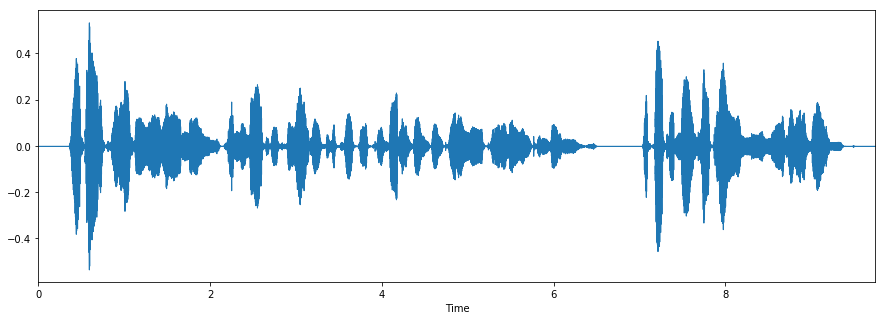

In [757]:
sr_data_utils.plot_wave(audio_paths[1])

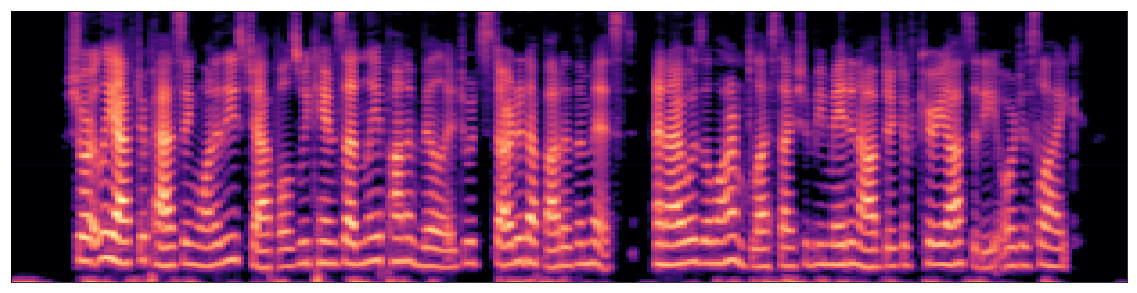

In [758]:
sr_data_utils.plot_melspectogram(audio_paths[0])

### Process texts


In [759]:
# the 'process_txts' function calls 'split_txts', 'create_lookup_dicts' and 'convert_txt_to_inds' internally.
specials = ['<EOS>', '<SOS>', '<PAD>']
txts_splitted, unique_chars, char2ind, ind2char, txts_converted = sr_data_utils.process_txts(txts, specials)

In [760]:
print(len(char2ind), len(ind2char))

30 30


In [761]:
# before conversion
print('First txt:', txts[0])

First txt: SHORTLY AFTER PASSING ONE OF THESE CHAPELS WE CAME SUDDENLY UPON A VILLAGE WHICH STARTED UP OUT OF THE MIST AND I WAS ALARMED LEST I SHOULD BE MADE AN OBJECT OF CURIOSITY OR DISLIKE


In [762]:
# splitted
print('First txt splitted:', txts_splitted[0])

First txt splitted: ['S', 'H', 'O', 'R', 'T', 'L', 'Y', '<SPACE>', 'A', 'F', 'T', 'E', 'R', '<SPACE>', 'P', 'A', 'S', 'S', 'I', 'N', 'G', '<SPACE>', 'O', 'N', 'E', '<SPACE>', 'O', 'F', '<SPACE>', 'T', 'H', 'E', 'S', 'E', '<SPACE>', 'C', 'H', 'A', 'P', 'E', 'L', 'S', '<SPACE>', 'W', 'E', '<SPACE>', 'C', 'A', 'M', 'E', '<SPACE>', 'S', 'U', 'D', 'D', 'E', 'N', 'L', 'Y', '<SPACE>', 'U', 'P', 'O', 'N', '<SPACE>', 'A', '<SPACE>', 'V', 'I', 'L', 'L', 'A', 'G', 'E', '<SPACE>', 'W', 'H', 'I', 'C', 'H', '<SPACE>', 'S', 'T', 'A', 'R', 'T', 'E', 'D', '<SPACE>', 'U', 'P', '<SPACE>', 'O', 'U', 'T', '<SPACE>', 'O', 'F', '<SPACE>', 'T', 'H', 'E', '<SPACE>', 'M', 'I', 'S', 'T', '<SPACE>', 'A', 'N', 'D', '<SPACE>', 'I', '<SPACE>', 'W', 'A', 'S', '<SPACE>', 'A', 'L', 'A', 'R', 'M', 'E', 'D', '<SPACE>', 'L', 'E', 'S', 'T', '<SPACE>', 'I', '<SPACE>', 'S', 'H', 'O', 'U', 'L', 'D', '<SPACE>', 'B', 'E', '<SPACE>', 'M', 'A', 'D', 'E', '<SPACE>', 'A', 'N', '<SPACE>', 'O', 'B', 'J', 'E', 'C', 'T', '<SPACE>', 'O'

In [763]:
# after conversion
print('First txt converted:', txts_converted[0])

First txt converted: [1, 22, 11, 18, 21, 23, 15, 28, 3, 4, 9, 23, 8, 21, 3, 19, 4, 22, 22, 12, 17, 10, 3, 18, 17, 8, 3, 18, 9, 3, 23, 11, 8, 22, 8, 3, 6, 11, 4, 19, 8, 15, 22, 3, 26, 8, 3, 6, 4, 16, 8, 3, 22, 24, 7, 7, 8, 17, 15, 28, 3, 24, 19, 18, 17, 3, 4, 3, 25, 12, 15, 15, 4, 10, 8, 3, 26, 11, 12, 6, 11, 3, 22, 23, 4, 21, 23, 8, 7, 3, 24, 19, 3, 18, 24, 23, 3, 18, 9, 3, 23, 11, 8, 3, 16, 12, 22, 23, 3, 4, 17, 7, 3, 12, 3, 26, 4, 22, 3, 4, 15, 4, 21, 16, 8, 7, 3, 15, 8, 22, 23, 3, 12, 3, 22, 11, 18, 24, 15, 7, 3, 5, 8, 3, 16, 4, 7, 8, 3, 4, 17, 3, 18, 5, 13, 8, 6, 23, 3, 18, 9, 3, 6, 24, 21, 12, 18, 22, 12, 23, 28, 3, 18, 21, 3, 7, 12, 22, 15, 12, 14, 8, 0]


In [764]:
# converted back.
# seems to have worked well.
# Note: <SOS> and <EOS> token were added at start and end of txt. 
print('First txt converted back:', sr_data_utils.convert_inds_to_txt(txts_converted[0], ind2char))

First txt converted back: ['<SOS>', 'S', 'H', 'O', 'R', 'T', 'L', 'Y', '<SPACE>', 'A', 'F', 'T', 'E', 'R', '<SPACE>', 'P', 'A', 'S', 'S', 'I', 'N', 'G', '<SPACE>', 'O', 'N', 'E', '<SPACE>', 'O', 'F', '<SPACE>', 'T', 'H', 'E', 'S', 'E', '<SPACE>', 'C', 'H', 'A', 'P', 'E', 'L', 'S', '<SPACE>', 'W', 'E', '<SPACE>', 'C', 'A', 'M', 'E', '<SPACE>', 'S', 'U', 'D', 'D', 'E', 'N', 'L', 'Y', '<SPACE>', 'U', 'P', 'O', 'N', '<SPACE>', 'A', '<SPACE>', 'V', 'I', 'L', 'L', 'A', 'G', 'E', '<SPACE>', 'W', 'H', 'I', 'C', 'H', '<SPACE>', 'S', 'T', 'A', 'R', 'T', 'E', 'D', '<SPACE>', 'U', 'P', '<SPACE>', 'O', 'U', 'T', '<SPACE>', 'O', 'F', '<SPACE>', 'T', 'H', 'E', '<SPACE>', 'M', 'I', 'S', 'T', '<SPACE>', 'A', 'N', 'D', '<SPACE>', 'I', '<SPACE>', 'W', 'A', 'S', '<SPACE>', 'A', 'L', 'A', 'R', 'M', 'E', 'D', '<SPACE>', 'L', 'E', 'S', 'T', '<SPACE>', 'I', '<SPACE>', 'S', 'H', 'O', 'U', 'L', 'D', '<SPACE>', 'B', 'E', '<SPACE>', 'M', 'A', 'D', 'E', '<SPACE>', 'A', 'N', '<SPACE>', 'O', 'B', 'J', 'E', 'C', 'T',

In [ ]:
# write lookup dicts to .pkl for later use. 
sr_data_utils.write_pkl('./pickles/sr_word2ind.pkl', word2ind)
sr_data_utils.write_pkl('./pickles/sr_ind2word.pkl', ind2word)

### Sort

The audios in the dataset differ massively in length. In order to simplify the training process for the model and due to, again, limited resources we will sort them by length and use rather short ones. 
Furthermore the model seems to train better, when first feeded rather short examples.

In [765]:
for t, a in zip(txts[:30], audios[:30]):
    print(len(t), a.shape[0])

181 494
171 486
57 202
150 406
164 519
84 291
185 510
140 420
47 136
175 520
140 396
90 296
139 405
55 195
295 879
200 568
139 421
126 348
234 604
138 373
131 398
108 305
59 176
35 132
63 209
25 127
48 161
101 329
178 474
153 435


In [766]:
# Sort texts by text length or audio length from shortest to longest.
# To keep everything in order we also sort the rest of the data.
txts, audios, audio_paths, txts_splitted, txts_converted = sr_data_utils.sort_by_length(audios,
                                                                                        txts,
                                                                                        audio_paths,
                                                                                        txts_splitted,
                                                                                        txts_converted,
                                                                                        by_text_length=False)


In [767]:
for t, a in zip(txts[:30], audios[:30]):
    print(len(t), a.shape[0])

3 72
16 75
8 76
17 78
12 82
6 83
14 84
14 86
9 87
8 87
13 87
8 88
6 88
17 88
10 90
16 92
18 92
15 92
11 92
24 93
27 93
32 94
22 95
26 96
28 97
17 97
34 97
24 97
28 97
26 97


Text(0.5,1,'Distribution of text lengths')

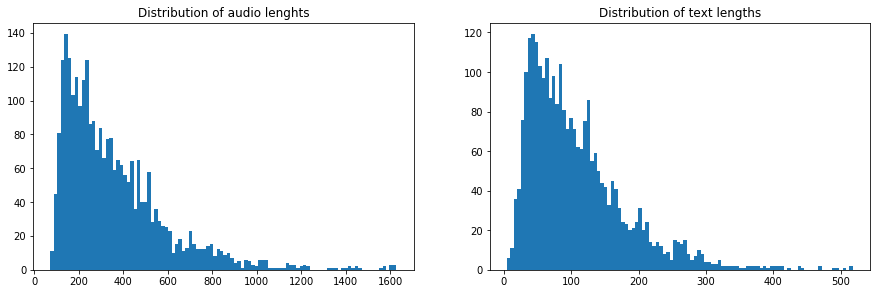

In [768]:
# Quicklook at length distributions.
# obviously they correlate well with each other. 
plt.figure(figsize=(15,10))
plt.subplot(221)
plt.hist([a.shape[0] for a in audios], bins=100)
plt.title('Distribution of audio lenghts')

plt.subplot(222)
plt.hist([len(t) for t in txts_converted], bins=100)
plt.title('Distribution of text lengths')

## Model

Now we can start training our the model.


### Train

Create SpeechRecognizer, build the graph and train the network.

In [ ]:
# nice extension ==> avoids having to restart kernel everytime changes are made.
%load_ext autoreload
%autoreload 2

In [ ]:
sr_model_utils.reset_graph()
sr = SpeechRecognizer.SpeechRecognizer(char2ind,
                                       ind2char,
                                       './models/models_1000points_0/my_model',
                                       num_layers_encoder=2,
                                       num_layers_decoder=2,
                                       rnn_size_encoder=450,
                                       rnn_size_decoder=450,
                                       embedding_dim=10,
                                       batch_size=40,
                                       epochs=500,
                                       use_cyclic_lr=True,
                                       learning_rate=0.00001,
                                       max_lr=0.00003,
                                       learning_rate_decay_steps=700)

sr.build_graph()
sr.train(audios[:1000],
         txts_converted[:1000],
         restore_path='./models/models_1000points_0/my_model')

# we are terribly overfitting here. therefore it won't generalize well.
# Note: hidden training process. Loss decreased to about 0.4

### Test 

In [810]:
sr_model_utils.reset_graph()
sr = SpeechRecognizer.SpeechRecognizer(char2ind,
                                       ind2char,
                                       './models/models_1000points_0/my_model',
                                       num_layers_encoder=2,
                                       num_layers_decoder=2,
                                       rnn_size_encoder=450,
                                       rnn_size_decoder=450,
                                       mode='INFER',
                                       embedding_dim=10,
                                       batch_size=1,
                                       beam_width=5)

sr.build_graph()
preds = sr.infer(audios[0:500:20],
                './models/models_1000points_0/my_model')

Graph built.
INFO:tensorflow:Restoring parameters from ./models/models_1000points_0/my_model
Done restoring.


In [811]:
# preds2txt converts the predictions to text and removes <EOS> and <SOS> tags.
preds_converted = sr_data_utils.preds2txt(preds, ind2char, beam=True)

In [812]:
# prints the created texts side by side with the actual texts and 
# prints out an accuracy score of how good the prediction was.
# if the created text is shorter than the actual one we
# penalize by subtracting 0.3 (pretty hard!)
# the accuracy clearly suffers, as the sequences get longer. 
sr_data_utils.print_samples(preds_converted, txts_splitted[0:500:20])


Created: ['Y', 'E', 'S']
Actual: ['Y', 'E', 'S']
Accuracy score: 1.0 


Created: ['W', 'H', 'Y', '<SPACE>', 'D', 'O', 'N', '<SPACE>', 'T', '<SPACE>', 'Y', 'O', 'U', '<SPACE>', 'M', 'O', 'V', 'E', '<SPACE>', 'T', 'H', 'E', '<SPACE>', 'P', 'O', 'N', 'Y']
Actual: ['W', 'H', 'Y', '<SPACE>', 'D', 'O', 'N', '<SPACE>', 'T', '<SPACE>', 'Y', 'O', 'U', '<SPACE>', 'M', 'O', 'V', 'E', '<SPACE>', 'T', 'H', 'E', '<SPACE>', 'P', 'O', 'N', 'Y']
Accuracy score: 1.0 


Created: ['D', 'E', 'L', 'I', 'G', 'H', 'T', 'E', 'D', '<SPACE>', 'T', 'O', '<SPACE>', '<SPACE>', 'S', 'E', '<SPACE>', 'Y', 'Y', 'O', 'U', '<SPACE>', 'M', 'I', 'S', 'T', 'E', 'R', '<SPACE>', 'K', 'E', 'E', 'K']
Actual: ['D', 'E', 'L', 'I', 'G', 'H', 'T', 'E', 'D', '<SPACE>', 'T', 'O', '<SPACE>', 'S', 'E', 'E', '<SPACE>', 'Y', 'O', 'U', '<SPACE>', 'M', 'I', 'S', 'T', 'E', 'R', '<SPACE>', 'M', 'E', 'E', 'K', 'I', 'N']
Accuracy score: 0.21515151515151515 


Created: ['S', 'E', 'V', 'E', 'N', 'T', 'E', 'E', 'N', '<SPACE>', 'S', 'E', 'V', 'E',

## Conclusion

Sequence to sequence models are really powerful and perform well on speech. However, here I could again only train our model on a really limited amount of data. It would be really interesting to scale this up and see how good it can get.

To sum up, speech recognition is already an important part and is going to play an even more crucial role in human-machine interaction in the near future. Therefore I am really curious to explore that topic more in depth.
(with hopefully more computing power)